# Search Trees

In this reading, we'll learn about how to use trees as an efficient way to search for data.

By the end, you should be comfortable with the following terms:
* binary tree
* search
* range query
* binary search tree
* balanced tree

formatting...

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from graphviz import Graph, Digraph

# Binary Tree

Below is a binary tree, cleaned up from last time.

Remember that a tree is a directed graph.  It has one root node (that is, a node without a parent).  Every other node has a parent.  Nodes without children are called leaves.

This tree is a *binary tree* because each node has at most two children.

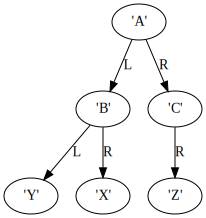

In [3]:
class Node:
    def __init__(self, val):
        self.val = val
        self.left = None
        self.right = None
    
    def to_graphviz(self, g=None):
        if g == None:
            g = Digraph()
            
        # draw self
        g.node(repr(self.val))
    
        for label, child in [("L", self.left), ("R", self.right)]:
            if child != None:
                # draw child, recursively
                child.to_graphviz(g)
                
                # draw edge from self to child
                g.edge(repr(self.val), repr(child.val), label=label)
        return g
    
    def _repr_svg_(self):
        return self.to_graphviz()._repr_image_svg_xml()
    
root = Node("A")
root.left = Node("B")
root.right = Node("C")
root.left.left = Node("Y")
root.left.right = Node("X")
root.right.right = Node("Z")
root

# Search

What if we want to check whether a tree *contains* a value?  We know it does if one of the following is true:

1. the root has that value
2. the left subtree contains that value
3. the right subtree contains that value

Let's write a recursive function, `contains`, to do this search.  At each step, we'll display the subtree being searched.

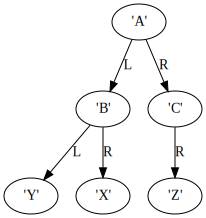

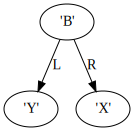

True

In [4]:
from IPython.core.display import display, HTML

def contains(node, target):
    if node == None:
        return False

    display(HTML("Is the root %s?" % target))
    display(node)

    if node.val == target:
        return True
    return contains(node.left, target) or contains(node.right, target)

contains(root, "B")

Cool, we found the value in the second place we looked because we check left first.  What if the data is deep on the right side?  Worse, what if the thing we're searching for isn't even in the tree?  Let's try that:

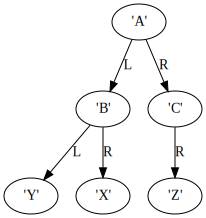

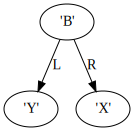

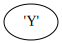

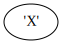

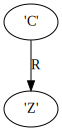

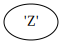

False

In [5]:
contains(root, "M")

# Search Tree

Ouch, that was slow.  It would be great if we could determine that an entry isn't in the tree without needing to look at every entry.

One way we can guarantee this is if every value in a left subtree is less than the value of the parent and every value in the right subtree is greater than the value of the parent.

## Constructing a Search Tree

Let's create a function for adding values that guarantees this.

In [6]:
# TODO: make this a method...
def add(node, val):
    if node.val == val:
        return # no duplicates
    elif val < node.val:
        if node.left != None:
            add(node.left, val)
        else:
            node.left = Node(val)
    else:
        if node.right != None:
            add(node.right, val)
        else:
            node.right = Node(val)

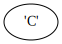

In [7]:
root = Node("C")
root

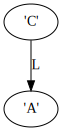

In [8]:
add(root, "A")
root

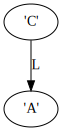

In [9]:
# duplicate shouldn't be added
add(root, "A")
root

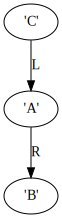

In [10]:
add(root, "B")
root

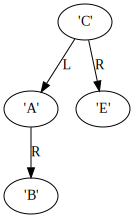

In [11]:
add(root, "E")
root

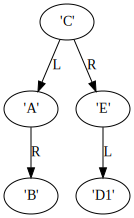

In [12]:
add(root, "D1")
root

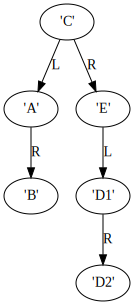

In [13]:
add(root, "D2")
root

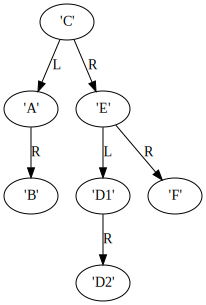

In [14]:
add(root, "F")
root

## Using a Search Tree

Now that we've built a search tree, we can write a function for efficiently searching it.  It's like the previous `contains` function, but now we only need to check one child instead of checking both each time.

'Is the root D2?'

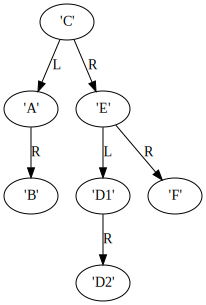

'Go Right'

'Is the root D2?'

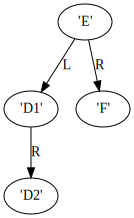

'Go Left'

'Is the root D2?'

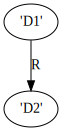

'Go Right'

'Is the root D2?'

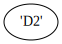

True

In [15]:
def contains(node, target):
    if node == None:
        return False

    display("Is the root %s?" % target)
    display(node)

    if node.val == target:
        return True
    
    if target < node.val:
        display("Go Left")
        return contains(node.left, target)
    else:
        display("Go Right")
        return contains(node.right, target)

contains(root, "D2")

# Range Query

For the previous lookups, using a Python set would probably do about as well.  But what if we want get all the values in some range?

We can write a similar function.  But now, we'll sometimes need to search both sides (depending on the width of the range).

Rather than returning found values, we can accumulate everything in a list.

'Is the root C between D1 and D9'

'NO'

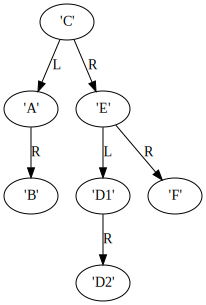

'Is the root E between D1 and D9'

'NO'

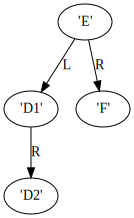

'Is the root D1 between D1 and D9'

'YES'

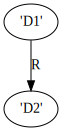

'Is the root D2 between D1 and D9'

'YES'

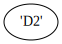

['D1', 'D2']

In [16]:
def range_query(node, lower, upper, results=None):
    if results == None:
        results = []

    if node == None:
        return results
        
    display("Is the root %s between %s and %s" % (node.val, str(lower), str(upper)))
    if lower <= node.val <= upper:
        display("YES")
        results.append(node.val)
    else:
        display("NO")
        
    display(node)

    if lower < node.val:
        range_query(node.left, lower, upper, results)
    if upper > node.val:
        range_query(node.right, lower, upper, results)

    return results

range_query(root, "D1", "D9")

# Balancing

If the depth of all nodes are roughly equal, the time to check a values will be O(log N), which is pretty great!  But the insertion order matters a lot.  Let's consider these 8 numbers:

In [17]:
nums1 = list(range(20))
nums1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [18]:
from numpy import random

nums2 = nums1[:] # shallow copy
random.seed(320)
random.shuffle(nums2)
nums2

[17, 9, 4, 18, 12, 7, 0, 6, 11, 15, 16, 3, 8, 1, 14, 19, 5, 10, 2, 13]

In [19]:
tree1 = Node(nums1[0])
for num in nums1[1:]:
    add(tree1, num)
    
tree2 = Node(nums2[0])
for num in nums2[1:]:
    add(tree2, num)

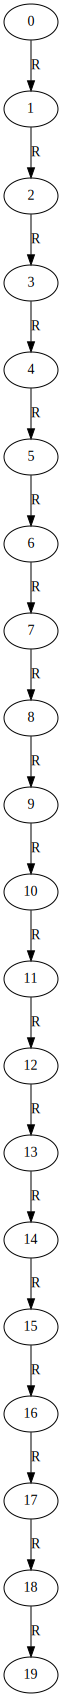

In [20]:
# lookup with be very slow!
tree1

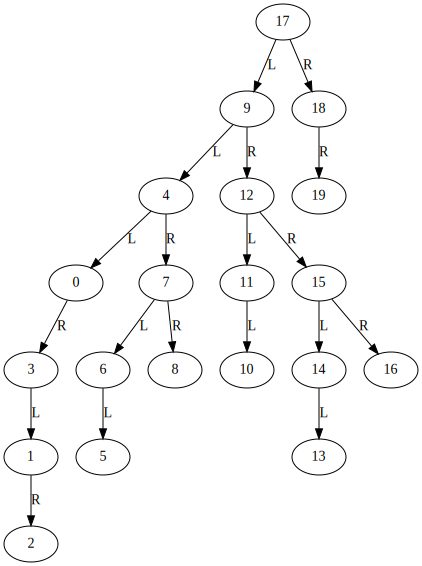

In [21]:
# a bit better!
tree2

# Balance

The second tree is definitely a lot more balanced than the first.  If we really want to measure this, we would like to identify openings that are shallower than the deepest nodes.

In [22]:
def nearest_open(node):
    if node is None:
        return 0
    return min(nearest_open(node.left), nearest_open(node.right)) + 1

def max_depth(node):
    if node is None or (node.left is None and node.right is None):
        return 0
    return 1 + max(max_depth(node.left), max_depth(node.right))

nearest_open(tree2), max_depth(tree2)

(2, 6)

In [23]:
def is_balanced(node):
    return nearest_open(node) >= max_depth(node)

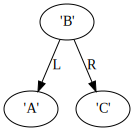

In [24]:
# test is_balanced
t = Node("B")
t.left = Node("A")
t.right = Node("C")
t

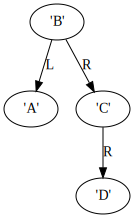

True

In [25]:
t.right.right = Node("D")
display(t)
is_balanced(t)

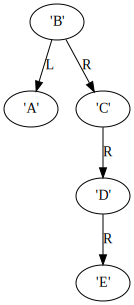

False

In [26]:
t.right.right.right = Node("E")
display(t)
is_balanced(t)

# Conclusion

In this reading, we have seen that a binary tree is a BST (Binary Search Tree) if all the left descendents of a node have lesser values than the node, and all the right descendents have greater values.  Binary search trees allow us to find values and ranges of values without checking every node.

In a perfectly balanced tree, looking for a single item is O(log N).  A tree if balanced if there are no nodes that could be moved closer to the root.

Randomizing insertion order can improve balance.  There are also algorithms (not covered) to rearrange trees as values are inserted, maintaining balance (perhaps within some tolerance).